#### SHAP Parameter Importance Ranking  
by: Angel Moreno

Below I am defining the predictor variables and target variable for this analysis.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
import warnings
from contextlib import redirect_stdout
import io
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor
from pytorch_tabnet.tab_model import TabNetRegressor
import shap
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error

In [3]:
# master data here
df_2017 = pd.read_csv("../finished_csvs/master_2017.csv")
df_2018 = pd.read_csv("../finished_csvs/master_2018.csv")
df_2019 = pd.read_csv("../finished_csvs/master_2019.csv")
df_2020 = pd.read_csv("../finished_csvs/master_2020.csv")
df_2021 = pd.read_csv("../finished_csvs/master_2021.csv")
df_2022 = pd.read_csv("../finished_csvs/master_2022.csv")
df_2023 = pd.read_csv("../finished_csvs/master_2023.csv")
df_2024 = pd.read_csv("../finished_csvs/master_2024.csv")

dfs = [df_2017, df_2018, df_2019, df_2020,
       df_2021, df_2022, df_2023, df_2024]

print(df_2017.columns)
print(f"This shape should be uniform across all dfs: {df_2017.shape}")

Index(['County', 'GEOID', 'A00', 'A01', 'A02', 'A03', 'A04', 'A05', 'A06',
       'A07', 'A08', 'A09', 'A10', 'A11', 'A12', 'A13', 'A14', 'A15', 'A16',
       'A17', 'A18', 'A19', 'A20', 'A21', 'A22', 'A23', 'A24', 'A25', 'A26',
       'A27', 'A28', 'A29', 'A30', 'A31', 'A32', 'A33', 'A34', 'A35', 'A36',
       'A37', 'A38', 'A39', 'A40', 'A41', 'A42', 'A43', 'A44', 'A45', 'A46',
       'A47', 'A48', 'A49', 'A50', 'A51', 'A52', 'A53', 'A54', 'A55', 'A56',
       'A57', 'A58', 'A59', 'A60', 'A61', 'A62', 'A63', 'Cases_2017',
       '2017_population', 'Cases_2017_normalized'],
      dtype='object')
This shape should be uniform across all dfs: (102, 69)


In [5]:
# these will be the same predictor variables for all 8 csv files (2017-2024)
# df_2017.columns[2:66]
predictors = ['A00', 'A01', 'A02', 'A03', 'A04', 'A05', 'A06',
       'A07', 'A08', 'A09', 'A10', 'A11', 'A12', 'A13', 'A14', 'A15', 'A16',
       'A17', 'A18', 'A19', 'A20', 'A21', 'A22', 'A23', 'A24', 'A25', 'A26',
       'A27', 'A28', 'A29', 'A30', 'A31', 'A32', 'A33', 'A34', 'A35', 'A36',
       'A37', 'A38', 'A39', 'A40', 'A41', 'A42', 'A43', 'A44', 'A45', 'A46',
       'A47', 'A48', 'A49', 'A50', 'A51', 'A52', 'A53', 'A54', 'A55', 'A56',
       'A57', 'A58', 'A59', 'A60', 'A61', 'A62', 'A63']
# likewise, this will be the same target variable ('Cases_20XX_normalized')
# always at the end of the dfs
example_Y = df_2017.columns[-1]

print(predictors)
print('\n')
print(example_Y)

['A00', 'A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'A07', 'A08', 'A09', 'A10', 'A11', 'A12', 'A13', 'A14', 'A15', 'A16', 'A17', 'A18', 'A19', 'A20', 'A21', 'A22', 'A23', 'A24', 'A25', 'A26', 'A27', 'A28', 'A29', 'A30', 'A31', 'A32', 'A33', 'A34', 'A35', 'A36', 'A37', 'A38', 'A39', 'A40', 'A41', 'A42', 'A43', 'A44', 'A45', 'A46', 'A47', 'A48', 'A49', 'A50', 'A51', 'A52', 'A53', 'A54', 'A55', 'A56', 'A57', 'A58', 'A59', 'A60', 'A61', 'A62', 'A63']


Cases_2017_normalized


#### CatBoost Model Performance

CatBoost is a gradient boosting based model that is excellent when there is a lot of categorical data. 

In [5]:
# # dfs_testing = [df_2017]
# avg_rmse_scores_2017_2024 = []

# # keep 5 for now but maybe increase if it runs somewhat fast
# kfold = KFold(n_splits=5, shuffle=True, random_state = 27)

# count = 0
# year = 2017

# for df in dfs:
#   count += 1
#   print(f"processing {count}/8")
#   # only need to redefine Y var
#   X = df[predictors]
#   Y = df[df.columns[-1]]
#   # https://catboost.ai/docs/en/concepts/parameter-tuning
#   catboost = CatBoostRegressor(
#     # default is 1000, but I will use 2000 since this is a smaller dataset
#     iterations=2000,
#     # depth 6 to 10 recommended
#     depth=8,
#     loss_function='RMSE',
#     verbose=False,
#     random_seed = 27
#   )

#   score = cross_val_score(catboost, X, Y, cv=kfold, scoring="neg_root_mean_squared_error")
#   pos_score = -score
#   avg_rmse_scores_2017_2024.append({
#     "year":year,
#     "rmse":pos_score.mean()
#   })

#   year += 1
# # end of model validation

In [ ]:
avg_rmse_scores_2017_2024

[{'year': 2017, 'rmse': np.float64(1.252681326251258)},
 {'year': 2018, 'rmse': np.float64(2.0558699845501422)},
 {'year': 2019, 'rmse': np.float64(1.295106391978416)},
 {'year': 2020, 'rmse': np.float64(0.2698741270348198)},
 {'year': 2021, 'rmse': np.float64(0.3082954710613737)},
 {'year': 2022, 'rmse': np.float64(0.36875699042322657)},
 {'year': 2023, 'rmse': np.float64(1.1491637791879044)},
 {'year': 2024, 'rmse': np.float64(0.33702369708109414)}]

In [ ]:
# output:
# [{'year': 2017, 'rmse': np.float64(1.252681326251258)},
#  {'year': 2018, 'rmse': np.float64(2.0558699845501422)},
#  {'year': 2019, 'rmse': np.float64(1.295106391978416)},
#  {'year': 2020, 'rmse': np.float64(0.2698741270348198)},
#  {'year': 2021, 'rmse': np.float64(0.3082954710613737)},
#  {'year': 2022, 'rmse': np.float64(0.36875699042322657)},
#  {'year': 2023, 'rmse': np.float64(1.1491637791879044)},
#  {'year': 2024, 'rmse': np.float64(0.33702369708109414)}]

#### TabNet Model Performance

TabNet is a deep learning model created for tabular data.

In [ ]:
# def tabnet_cv_rmse(X, y, k=5):
#   '''
#   Ignore early stoppage and record avg rmse for ONE day only. 
#   '''
#   kfold = KFold(n_splits=k, shuffle=True, random_state=27)
#   fold_rmses = []
#   warnings.filterwarnings("ignore")

#   # since tabnet does not support sklearn cross validation
#   # we will manually compute rmse for each fold
#   for train_idx, test_idx in kfold.split(X):
#     X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
#     y_train, y_test = y[train_idx], y[test_idx]

#     model = TabNetRegressor(
#       n_d=8, n_a=8, n_steps=3,
#       gamma=1.5, lambda_sparse=1e-4,
#       seed=27, verbose=0
#     )

#     # --- suppress TabNet's early stopping printouts ---
#     # this is so I can actually record the best RMSE for each year and get the average
#     f = io.StringIO()
#     with redirect_stdout(f):
#       model.fit(
#         X_train.values,
#         y_train.reshape(-1, 1),
#         eval_set=[(X_test.values, y_test.reshape(-1, 1))],
#         eval_metric=['rmse'],
#         max_epochs=200,
#         patience=20,
#         batch_size=64,
#         virtual_batch_size=32)

#     preds = model.predict(X_test.values).reshape(-1)
#     rmse = np.sqrt(mean_squared_error(y_test, preds))
#     fold_rmses.append(rmse)

#   # return avg 5 fold rmse for current year
#   return np.mean(fold_rmses)

In [ ]:
# results = {}
# dfs_testing = [df_2017]

# year = 2017
# for df in dfs:
#   print(f"processing: {year}")
#   X = df[predictors]
#   y = df[df.columns[-1]].values
#   avg_rmse = tabnet_cv_rmse(X, y)
#   results[df.columns[-1]] = avg_rmse
#   year += 1

processing: 2017
processing: 2018
processing: 2019
processing: 2020
processing: 2021
processing: 2022
processing: 2023
processing: 2024


In [ ]:
results

{'Cases_2017_normalized': np.float64(1.0637535650384204),
 'Cases_2018_normalized': np.float64(1.815861333367744),
 'Cases_2019_normalized': np.float64(1.1135452653746047),
 'Cases_2020_normalized': np.float64(0.21372876809420177),
 'Cases_2021_normalized': np.float64(0.29463561869059474),
 'Cases_2022_normalized': np.float64(0.34777232804185193),
 'Cases_2023_normalized': np.float64(1.2375243289851097),
 'Cases_2024_normalized': np.float64(0.3293317663979392)}

Catboost and TabNet final results:

CatBoost 5-fold cross validation mean rmse for each year: 

[{'year': 2017, 'rmse': np.float64(1.252681326251258)},     
 {'year': 2018, 'rmse': np.float64(2.0558699845501422)},    
 {'year': 2019, 'rmse': np.float64(1.295106391978416)},   
 {'year': 2020, 'rmse': np.float64(0.2698741270348198)},    
 {'year': 2021, 'rmse': np.float64(0.3082954710613737)},    
 {'year': 2022, 'rmse': np.float64(0.36875699042322657)},   
 {'year': 2023, 'rmse': np.float64(1.1491637791879044)},    
 {'year': 2024, 'rmse': np.float64(0.33702369708109414)}]   


TabNet 5-fold cross validation mean rmse for each year: 

{'Cases_2017_normalized': np.float64(1.0637535650384204),   
 'Cases_2018_normalized': np.float64(1.815861333367744),    
 'Cases_2019_normalized': np.float64(1.1135452653746047),   
 'Cases_2020_normalized': np.float64(0.21372876809420177),    
 'Cases_2021_normalized': np.float64(0.29463561869059474),    
 'Cases_2022_normalized': np.float64(0.34777232804185193),    
 'Cases_2023_normalized': np.float64(1.2375243289851097),   
 'Cases_2024_normalized': np.float64(0.3293317663979392)}   

So in general, the performance is very similar between the two. CatBoost is better (lower RMSE values for a given year) in some years while TabNet is very close in performance most years. Overall, TabNet seems to be producing the lower RMSE overall. 

#### SHAP-TabNet Ranking for 2017-2024

Now that I have seen and recorded TabNet's performance against CatBoost, I will now produce the SHAP plots for 2017-2024.       
The plots will be beeswarm and  bar plots. 

In [6]:
year = 2017
# dfs_testing = [df_2017,df_2018]
df_save = pd.DataFrame() # empty df for now, will append series

for df in dfs:
    print(f"training TabNet for {year}")
    ##### same as cv section #####
    X = df[predictors]
    Y = df[df.columns[-1]]

    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=27)

    # https://dreamquark-ai.github.io/tabnet/generated_docs/README.html
    model = TabNetRegressor(
        # default 8, n_d = n_a recommended
        n_d=8, 
        n_a=8, 
        # default = 3, good for smaller datasets
        n_steps=3,
        # feature reuse (1.0 to 2.0)
        gamma=1.5, 
        lambda_sparse=1e-4,
        seed=27, verbose=0
    )

    model.fit(
        X_train.values,
        y_train.values.reshape(-1, 1),
        eval_set=[(X_test.values, y_test.values.reshape(-1, 1))],
        eval_metric=['rmse'],
        # default 200
        max_epochs=200,
        # max num epochs without any change before early stoppage
        patience=20,
        batch_size=64,
        virtual_batch_size=32
    )
    ##### end training #####

    shap_values, masks = model.explain(X_test.values)

    mean_abs_shap = pd.Series(np.mean(np.abs(shap_values), axis=0), index=X_test.columns)

    # change 12/1/25 -> normalize on the max and not the sum (for bar plot)
    # normalized values on the max will be used for the heatmap as well (see next section)

    shap_normalized = mean_abs_shap / mean_abs_shap.max()

    df_save[year] = shap_normalized

    # ignoring sorting for now
    # mean_abs_shap = mean_abs_shap.sort_values(ascending=False)

    print(f"Plotting SHAP values for {year}")

    # save path for the plots
    beeswarm_summary_path = "../shap_plots/beeswarm_plots/"
    bar_plots_path = "../shap_plots/bar_plots/"

    os.makedirs(beeswarm_summary_path, exist_ok=True)
    os.makedirs(bar_plots_path, exist_ok=True)

    file_path_beeswarm = os.path.join(beeswarm_summary_path, f'beeswarm_plot_for_{year}.png')
    file_path_bar = os.path.join(bar_plots_path, f'bar_plot_for_{year}.png')

    # first plot -> beeswarm plot for all 64 features 
    # note: beeswarm plots do not need normalization
    plt.title(f'TabNet SHAP Feature Importance - {df.columns[-1].replace("_", " ")}')
    # this uses NOT normalized shap_values.
    shap_exp = shap.Explanation(values = shap_values, data = X_test.values, feature_names = X_test.columns)
    shap.plots.beeswarm(shap_exp, max_display=64, show=False)
    # plt.show()
    fig = plt.gcf()
    plt.savefig(file_path_beeswarm, dpi=300, bbox_inches="tight")
    plt.close(fig)

    # second plot -> bar plot for all 64 features 
    plt.figure(figsize=(10,6))
    shap_normalized.plot(kind='bar')
    plt.title(f'TabNet SHAP Feature Importance - {df.columns[-1].replace("_", " ")}')
    plt.ylabel('Normalized Mean Abs. SHAP value')
    plt.xlabel('Features')
    # plt.show()
    plt.savefig(file_path_bar, dpi=300, bbox_inches="tight")
    plt.close()

    year += 1

training TabNet for 2017

Early stopping occurred at epoch 34 with best_epoch = 14 and best_val_0_rmse = 0.95068
Plotting SHAP values for 2017


c:\Users\slplm\Desktop\embeddings\.venv\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


training TabNet for 2018

Early stopping occurred at epoch 31 with best_epoch = 11 and best_val_0_rmse = 1.72307


c:\Users\slplm\Desktop\embeddings\.venv\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Plotting SHAP values for 2018
training TabNet for 2019

Early stopping occurred at epoch 22 with best_epoch = 2 and best_val_0_rmse = 0.57773
Plotting SHAP values for 2019


c:\Users\slplm\Desktop\embeddings\.venv\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


training TabNet for 2020

Early stopping occurred at epoch 20 with best_epoch = 0 and best_val_0_rmse = 0.16206
Plotting SHAP values for 2020


c:\Users\slplm\Desktop\embeddings\.venv\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


training TabNet for 2021

Early stopping occurred at epoch 28 with best_epoch = 8 and best_val_0_rmse = 0.63656


c:\Users\slplm\Desktop\embeddings\.venv\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Plotting SHAP values for 2021
training TabNet for 2022

Early stopping occurred at epoch 20 with best_epoch = 0 and best_val_0_rmse = 0.57258
Plotting SHAP values for 2022


c:\Users\slplm\Desktop\embeddings\.venv\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


training TabNet for 2023

Early stopping occurred at epoch 80 with best_epoch = 60 and best_val_0_rmse = 1.41603
Plotting SHAP values for 2023


c:\Users\slplm\Desktop\embeddings\.venv\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


training TabNet for 2024

Early stopping occurred at epoch 20 with best_epoch = 0 and best_val_0_rmse = 0.32622
Plotting SHAP values for 2024


c:\Users\slplm\Desktop\embeddings\.venv\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [7]:
df_save

,2017,2018,2019,2020,2021,2022,2023,2024
A00,0.000000,0.000000,0.000000,0.000000,0.081928,0.000025,0.000000,0.017111
A01,0.000000,0.000000,0.104363,0.000000,0.000000,0.008452,0.000000,0.000000
A02,1.000000,0.000000,0.313165,0.837628,0.000876,0.096119,0.000000,0.596410
A03,0.072184,0.275355,0.295005,0.306179,0.000000,1.000000,0.000000,0.702514
A04,0.026346,0.377664,0.000000,0.060244,0.026417,0.362356,0.505969,0.025720
...,...,...,...,...,...,...,...,...
A59,0.000000,0.004137,0.000000,0.071120,0.000000,0.116342,0.000000,0.000000
A60,0.331957,0.004215,0.035422,0.564679,0.010268,0.308099,0.000000,0.000000
A61,0.000000,0.000000,0.000000,0.120102,0.000000,0.016140,0.001720,0.000000
A62,0.000000,0.005720,0.049942,0.000000,0.010437,0.071951,0.000000,0.000000


#### Heatmap creation - avg feature importance across all years 
https://www.datacamp.com/tutorial/seaborn-heatmaps

Next steps - heatmap with 9 columns and 64 rows.    
The ninth column will be the average across the years for a specific feature (example A00 avg is 0.24).          
Something like this: 

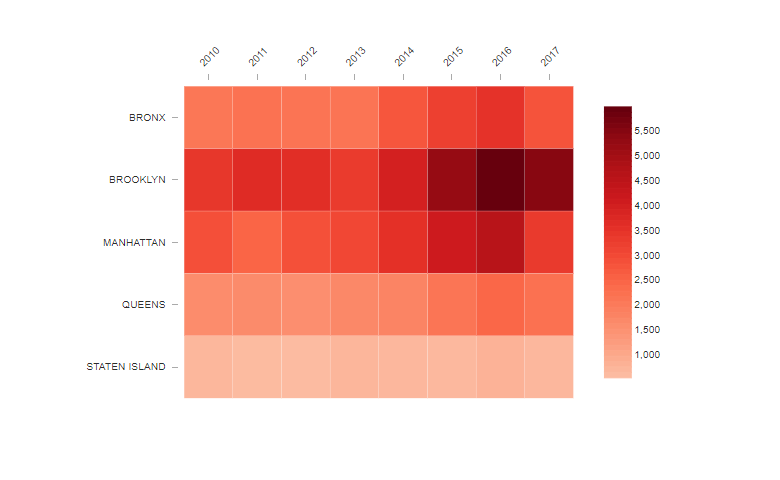  


After this heatmap, we will develop a threshold to select certain averages and keep the top n features.

With these top n features, we will develop a new model and measure the RMSE based on only keeping the most important features. 

In [ ]:
df_save["Overall"] = df_save.mean(axis=1)
# normalize overall on the max 
df_save["Overall"] = df_save["Overall"] / df_save["Overall"].max()

,2017,2018,2019,2020,2021,2022,2023,2024,Overall
A00,0.000000,0.000000,0.000000,0.000000,0.081928,0.000025,0.000000,0.017111,0.134834
A01,0.000000,0.000000,0.104363,0.000000,0.000000,0.008452,0.000000,0.000000,0.138127
A02,1.000000,0.000000,0.313165,0.837628,0.000876,0.096119,0.000000,0.596410,0.792211
A03,0.072184,0.275355,0.295005,0.306179,0.000000,1.000000,0.000000,0.702514,0.746003
A04,0.026346,0.377664,0.000000,0.060244,0.026417,0.362356,0.505969,0.025720,0.442709
...,...,...,...,...,...,...,...,...,...
A59,0.000000,0.004137,0.000000,0.071120,0.000000,0.116342,0.000000,0.000000,0.156993
A60,0.331957,0.004215,0.035422,0.564679,0.010268,0.308099,0.000000,0.000000,0.411560
A61,0.000000,0.000000,0.000000,0.120102,0.000000,0.016140,0.001720,0.000000,0.144149
A62,0.000000,0.005720,0.049942,0.000000,0.010437,0.071951,0.000000,0.000000,0.144170


In [ ]:
# df_save.to_csv("embeddings_importance_2017_to_2024.csv")

AttributeError: 'numpy.ndarray' object has no attribute 'tick_params'

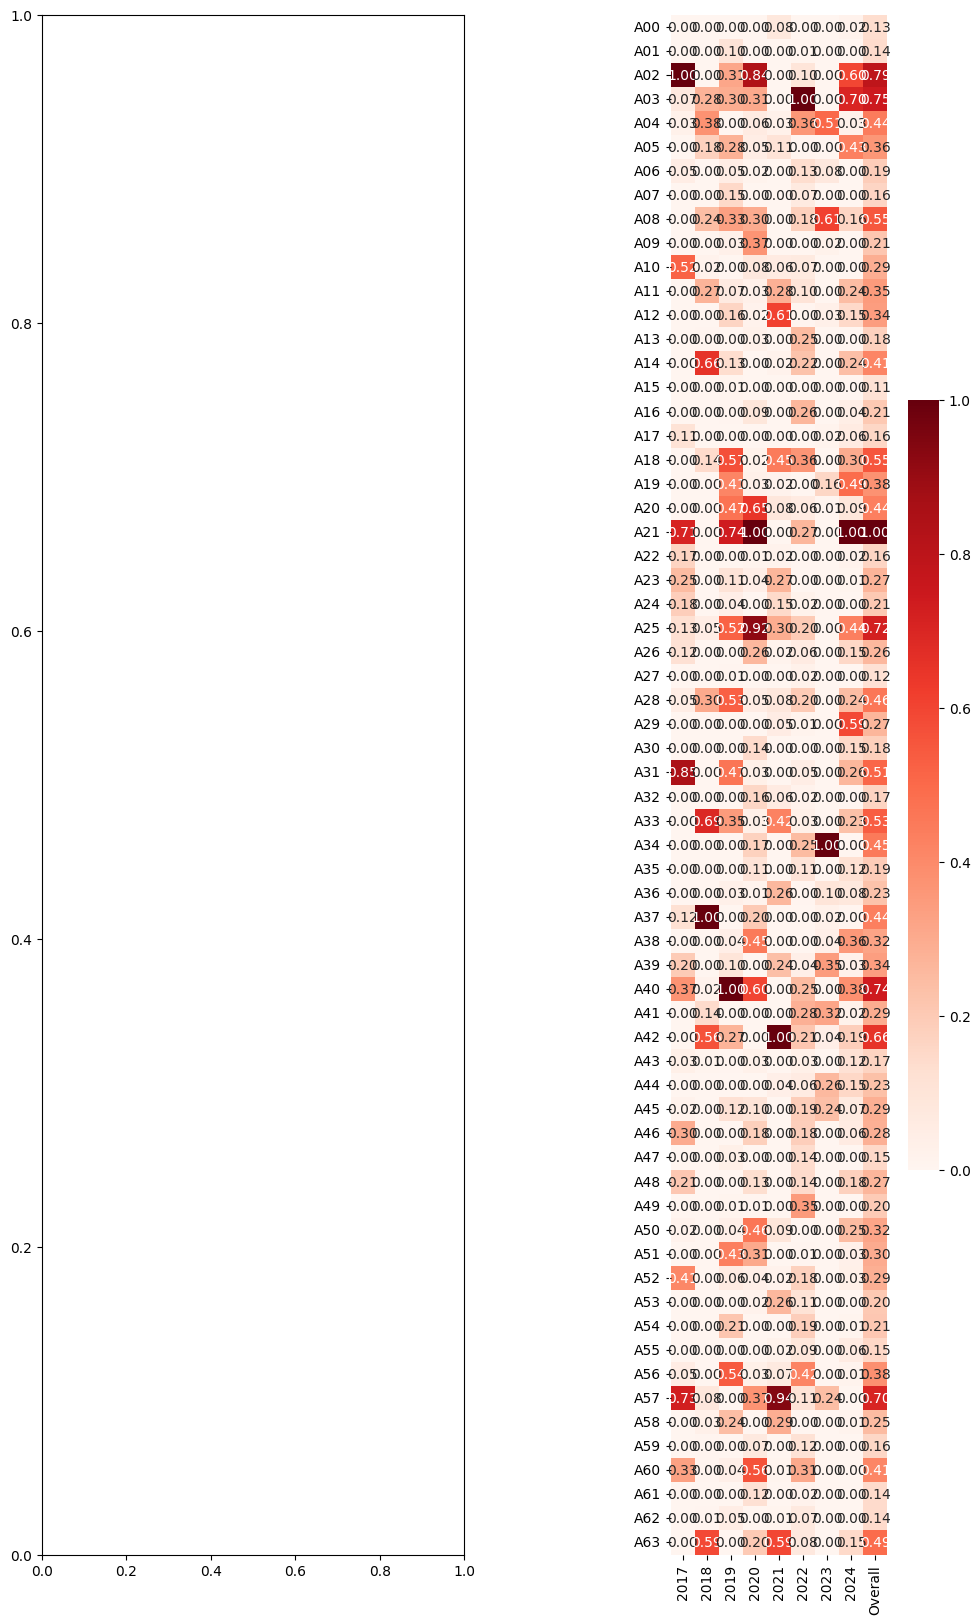

In [ ]:
# this is the heatmap, along with the added column at the end. 

# split into two subplots 

# plt.figure(figsize=(8,20))  
fig, axes = plt.subplots(ncols=2, figsize=(12, 20))
# if i do want numbers update annot param (can add this for nums fmt=".2f")
plt.rcParams.update({'font.size': 10})

axes[0] = sns.heatmap(df_save, cmap="Reds", annot=True, fmt=".2f", square=True, cbar_kws={"shrink": 0.5, "aspect": 25})
axes.tick_params(axis="x",labelsize=10) 

axes[1] = sns.heatmap(df_save, cmap="Reds", annot=True, fmt=".2f", square=False, cbar_kws={"shrink": 0.5, "aspect": 18})
axes.tick_params(axis="x",labelsize=10) 


fig.suptitle("Normalized SHAP Values (2017-2024)")
plt.show()


# smaller legend, and add label "Mean Normalized SHAP Value" to legend 
# one png with the two subplots 



# set up regression model
# 6 years training and 1 test

# grid search for hyperparameter tuning